In [1]:
import sys

import gym
import numpy as np
import scipy.integrate as sc_integrate

from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import A2C, DQN

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import sympy as sp
import pickle

## Mathematical system description with SymPy / symbtools

In [74]:
Np = 1 # number of passive coordinates (p = phi1)
Nq = 1 # number of actuated coordinates (q = x0)
n = Np + Nq
pp = st.symb_vector("p1:{0}".format(Np+1))
qq = st.symb_vector("q1:{0}".format(Nq+1))

# all coordinates and their derivatives
ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad)

F = sp.Symbol('F')

params = sp.symbols('m0, m1, l1, g, d0, d1')
st.make_global(params)
params_values = [(m0, 1.0), (m1, 0.1), (l1, 0.5), (g, 9.81),
                 (d0, 0.01), (d1, 0.01)]

In [75]:
# load model etc. from pickle of flatness analysis notebook
with open("../single_crane_notebooks/model_single_crane.pcl", "rb") as pfile:
    mod = pickle.load(pfile) # mod instead of data
    #locals().update(data)

In [76]:
mod.xx

Matrix([
[   p1],
[   q1],
[pdot1],
[qdot1]])

In [77]:
mod.calc_state_eq(force_recalculation=True)
mod.eqns

Matrix([
[            d0*pdot1 + g*l1*m1*sin(p1) + l1**2*m1*pddot1 - l1*m1*qddot1*cos(p1)],
[-Fcomp + 1.0*m0*qddot1 + m1*(-l1*pddot1*cos(p1) + l1*pdot1**2*sin(p1) + qddot1)]])

In [78]:
states_dot = mod.f + mod.g * F

In [79]:
states_dot_wo_params = states_dot.subs(params_values)

In [80]:
states_dot_func = st.expr_to_func([*mod.xx, F], states_dot_wo_params)

## pygent utility functions

In [9]:
def observation(x, xIsAngle):
    obsv = []
    for i, state in enumerate(x):
        if xIsAngle[i]:
            obsv.append(np.cos(state))
            obsv.append(np.sin(state))
        else:
            obsv.append(state)

    return np.array(obsv)

def mapAngles(xIsAngle, x, mod=np):
        """ Maps angles to the interval [-pi,pi]. """
        x_pi = []
        for i, state in enumerate(x):
            if xIsAngle[i]:
                # map theta to [-pi,pi]
                x_pi.append((state + mod.pi) % (2*mod.pi) - mod.pi)   
            else:
                x_pi.append(state)
        return x_pi

## Gym environment

In [104]:
from abc import abstractmethod
import gym
from gym import logger, spaces
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter, MultipleLocator
from scipy.integrate import solve_ivp
import inspect
import pickle
import copy

class Environment(gym.Env):
    """ Environment base class.

    Args:
        x0 (array, list, callable):

    Attributes:

        x (array): current state x[k] (size = n)
        x_ (array): previous state x[k-1](size = n)
        history (array): previous states (x[0],x[1],...,x[k-1])
        tt (list): time vector (corresponding to history)
        terminated (bool): True, if environment is in a terminal state

    """

    def __init__(self, x0, uDim, dt):
        if callable(x0):
            self.x0 = x0  # initial state
            x0 = x0()
        else:
            x0 = list(x0)
            self.x0 = x0
        self.x = x0  # current state
        self.x_ = x0 # previous state x[k-1]
        self.xDim = len(x0) # state dimension
        self.oDim = self.xDim # observation dimension
        self.uDim = uDim # inputs
        self.xIsAngle = np.zeros([self.xDim], dtype=bool)
        self.history = np.array([x0])
        self.tt = [0]
        self.terminated = False
        self.uMax = np.ones(uDim)
        self.dt = dt

    def get_state(self):
        return self.x

    def reset(self):
        """ Resets environment to state x0

        Args:
            x0 (array, list, callable): initial state

        """
        if callable(self.x0):
            x0 = self.x0()
        self.history = np.array([x0])
        self.x_ = x0
        self.x = x0
        self.tt = [0]
        self.terminated = False
        return np.array(self.x, dtype=np.float32)

    @abstractmethod
    def step(self, *args):
        return

    def plot(self):
        """ Plots the environments history

        Returns:
            fig (matplotlib.pyplot.figure)
            ax (matploltib.pyplot.axes)

        """

        fig, ax = plt.subplots(len(self.x), 1, dpi=300, sharex=True)
        # Plot state trajectories
        if len(self.x) > 1:
            for i in range(len(self.x)):
                ax[i].step(self.tt, self.history[:, i], 'b',  lw=1)
                ax[i].set_ylabel(r'$x_'+str(i+1)+'$')
                ax[i].grid(True)
                if self.xIsAngle[i]:
                    ax[i].yaxis.set_major_formatter(FuncFormatter(
                        lambda val, pos: '{:.0g}$\pi$'.format(val / np.pi) if val != 0 else '0'))
                    ax[i].yaxis.set_major_locator(MultipleLocator(base=np.pi))
        else:
            ax.step(self.tt, self.history[:, 0], 'b',  lw=1)
            ax.grid(True)
            plt.ylabel(r'$x_1$')
        fig.align_ylabels(ax)
        plt.xlabel(r't[s]')
        plt.tight_layout()
        # Todo: save data in numpy arrays
        return fig, ax

    def save_history(self, filename, path):
        history_dict = {'tt': self.tt, 'xx': self.history}
        pickle.dump(history_dict, open(path + filename +'.p', 'wb'))
        pass

    def animation(self):
        pass

    def observe(self, x):
        return x

class StateSpaceModel(Environment):
    """ Environment subclass that uses a state space model of the form dx/dt = f(x, u)
    to represent the environments dynamics.

    Args:
        ode
        cost
        x0
        uDim

    Attributes:
        ode (function): ODE for simulation
        cost (function): cost function (returns scalar)
        xIsAngle (ndarray): 'True' if state is an angle, 'False' otherwise
        o
        o_
        oDim

    """

    def __init__(self, ode, cost, x0, uDim, dt,
                 terminal_cost=0.):
        super(StateSpaceModel, self).__init__(x0, uDim, dt)
        self.ode = ode
        params = inspect.signature(cost).parameters
        cost_args = params.__len__()
        if cost_args == 1:
            self.cost = lambda x_, u_, x, t, mod: cost(x_)
        elif cost_args == 2:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_)
        elif cost_args == 3:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x)
        elif cost_args == 4:
            if 'mod' in params and 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t, mod)
            elif 'mod' in params and not 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, mod)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, t)
        elif cost_args == 5:
            self.cost = cost
        else:
            print('Cost function must to be of the form c(x_, u_, x, t, mod), where mod is numpy/sympy.')
            assert(True)
        self.xIsAngle = np.zeros([len(self.x_)], dtype=bool)
        self.o = self.x
        self.o_ = self.x_
        self.oDim = len(self.o)  # observation dimensions
        self.terminal_cost = terminal_cost

    def step(self, *args):
        """ Simulates the environment for 1 step of time t.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """
        self.x_ = self.x  # shift state (x[k-1] = x[k])
        self.o_ = self.o
        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        # system simulation
        sol = solve_ivp(lambda t, x: self.ode(t, x, u), (0, dt), self.x_, 'RK45')
        # todo: only output value of the last timestep
        y = list(sol.y[:, -1])  # extract simulation result
        self.x = y
        self.o = self.observe(self.x)
        self.history = np.concatenate((self.history, np.array([self.x])))  # save current state
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        #x_2pi = mapAngles(self.xIsAngle, self.x_)
        #x2pi = mapAngles(self.xIsAngle, self.x)
        #c = (self.cost(x_2pi, u, x2pi, np) + self.terminal_cost*self.terminated)*dt
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost * self.terminated) * dt
        return np.array(self.x, dtype=np.float32), -c, self.terminated, {"info": False}

    def terminate(self, x):
        """ Check if a 'terminal' state is reached.

            Args:
                x (ndarray, list): state

            Returns:
                terminated (bool): 'True' if 'x' is a terminal state. """

        terminated = False
        return terminated


    def fast_step(self, *args):
        """ Simulates the environment for 1 step of time t, using Euler forward integration.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """

        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        self.x_ = self.x  # shift state (x[k-1] := x[k])
        self.o_ = self.o

        # Euler forward step
        y = self.x_ + dt*self.ode(None, self.x_, u)
        self.x = y
        self.o = self.observe(self.x)
        self.history = np.concatenate((self.history, np.array([self.x])))  # save current state
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost*self.terminated)*dt
        return c

    def observe(self, x):
        obsv = observation(x, self.xIsAngle)
        return obsv

class Pendulum(StateSpaceModel):
    metadata = {}

    def __init__(self, cost, x0, dt):
        super(Pendulum, self).__init__(self.ode, cost, x0, 1, dt)
        self.xIsAngle = [True, False, False, False]
        self.o = self.observe(self.x)
        self.o_ = self.o
        self.oDim = len(self.o)  # observation dimensions
        self.uMax = 3.5*np.ones(1)
        
        high_obs = np.array(
            [
                100.0,
                100.0,
                100.0,
                100.0
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high_obs, high_obs, dtype=np.float32)
        
        high_act = np.array(
            [ 
                12
            ],
            dtype=np.float32,
        )
        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)

    @staticmethod
    def ode(t, x, u):

        dxdt = states_dot_func(*x, u)

        return np.array(dxdt, dtype=np.float32)

    def terminate(self, x):
        x1, x2, x3, x4 = x
        if abs(x3) > 10 or abs(x2) > 10 or abs(x1) > 8*np.pi:
            return True
        else:
            return False

## Kostenfunktion, Anfangswerte

In [105]:
# define the incremental cost
def c_k(x, u):
    x1, x2, x3, x4 = x
    x1, x3 = mapAngles([1,0], [x1, x3])
    u1, = u
    c = x1**2 + 0.05*x2**2 + 0.1*x3**2 + 0.05*x4**2 + 0.05*u1**2
    return c

# define the function, that represents the initial value distribution p(x_0)
def p_x0():
    x0 = [np.random.uniform(-0.001,0.001), np.random.uniform(-0.001,0.001), np.random.uniform(-0.001,0.001), np.random.uniform(-0.001,0.001)]
    return x0

t = 10 # time of an episode
dt = 0.05 # time step-size
learning_steps = 1e5 # define training duration

## Gym-Umgebung erstellen

In [106]:
# environment without renderings for training
env = Pendulum(c_k, p_x0, dt)

In [107]:
env.reset()
env.step(env.action_space.sample())
env.observation_space
check_env(env)

## Learning the model

In [108]:
%%time
# Learning!
model = A2C('MlpPolicy', env, verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/")
model.learn(total_timesteps=learning_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./a2c_cartpole_tensorboard/A2C_12
------------------------------------
| time/                 |          |
|    fps                | 340      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | 0.413    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.136    |
|    std                | 0.995    |
|    value_loss         | 0.00869  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 562      |
|    ep_rew_mean        | -31.6    |
| time/                 |          |
|    fps                | 341      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 158      |
|    ep_rew_mean        | -10.1    |
| time/                 |          |
|    fps                | 342      |
|    iterations         | 1400     |
|    time_elapsed       | 20       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -1.38    |
|    explained_variance | -0.306   |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -0.318   |
|    std                | 0.963    |
|    value_loss         | 0.0626   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 162      |
|    ep_rew_mean        | -10.3    |
| time/                 |          |
|    fps                | 343      |
|    iterations         | 1500     |
|    time_elapsed       | 21       |
|    total_timesteps    | 7500     |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 84.4     |
|    ep_rew_mean        | -7.01    |
| time/                 |          |
|    fps                | 344      |
|    iterations         | 2700     |
|    time_elapsed       | 39       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -1.37    |
|    explained_variance | -0.934   |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -0.144   |
|    std                | 0.956    |
|    value_loss         | 0.0154   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 82       |
|    ep_rew_mean        | -6.97    |
| time/                 |          |
|    fps                | 344      |
|    iterations         | 2800     |
|    time_elapsed       | 40       |
|    total_timesteps    | 14000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 118      |
|    ep_rew_mean        | -14.6    |
| time/                 |          |
|    fps                | 345      |
|    iterations         | 4000     |
|    time_elapsed       | 57       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -1.35    |
|    explained_variance | -47.3    |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 0.223    |
|    std                | 0.929    |
|    value_loss         | 0.0575   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 139      |
|    ep_rew_mean        | -17.5    |
| time/                 |          |
|    fps                | 345      |
|    iterations         | 4100     |
|    time_elapsed       | 59       |
|    total_timesteps    | 20500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 340      |
|    iterations         | 5300     |
|    time_elapsed       | 77       |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -1.14    |
|    explained_variance | -6.32    |
|    learning_rate      | 0.0007   |
|    n_updates          | 5299     |
|    policy_loss        | -0.0262  |
|    std                | 0.759    |
|    value_loss         | 0.000286 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 339      |
|    iterations         | 5400     |
|    time_elapsed       | 79       |
|    total_timesteps    | 27000    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 333       |
|    iterations         | 6600      |
|    time_elapsed       | 98        |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -0.859    |
|    explained_variance | 0.105     |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | -0.000114 |
|    std                | 0.571     |
|    value_loss         | 3.52e-06  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 333      |
|    iterations         | 6700     |
|    time_elapsed       | 100      |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 329       |
|    iterations         | 7900      |
|    time_elapsed       | 119       |
|    total_timesteps    | 39500     |
| train/                |           |
|    entropy_loss       | -0.609    |
|    explained_variance | 0.17      |
|    learning_rate      | 0.0007    |
|    n_updates          | 7899      |
|    policy_loss        | -0.000742 |
|    std                | 0.445     |
|    value_loss         | 1.32e-06  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 329      |
|    iterations         | 8000     |
|    time_elapsed       | 121      |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 326      |
|    iterations         | 9200     |
|    time_elapsed       | 140      |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -0.377   |
|    explained_variance | -12      |
|    learning_rate      | 0.0007   |
|    n_updates          | 9199     |
|    policy_loss        | 0.000312 |
|    std                | 0.353    |
|    value_loss         | 2.49e-06 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 326       |
|    iterations         | 9300      |
|    time_elapsed       | 142       |
|    total_timesteps    | 4650

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 324       |
|    iterations         | 10500     |
|    time_elapsed       | 161       |
|    total_timesteps    | 52500     |
| train/                |           |
|    entropy_loss       | -0.193    |
|    explained_variance | -0.000386 |
|    learning_rate      | 0.0007    |
|    n_updates          | 10499     |
|    policy_loss        | -0.000238 |
|    std                | 0.293     |
|    value_loss         | 6.91e-07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 324      |
|    iterations         | 10600    |
|    time_elapsed       | 163      |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 322       |
|    iterations         | 11800     |
|    time_elapsed       | 182       |
|    total_timesteps    | 59000     |
| train/                |           |
|    entropy_loss       | 0.0733    |
|    explained_variance | -0.535    |
|    learning_rate      | 0.0007    |
|    n_updates          | 11799     |
|    policy_loss        | -0.000522 |
|    std                | 0.225     |
|    value_loss         | 1.09e-06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 322       |
|    iterations         | 11900     |
|    time_elapsed       | 184       |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 321      |
|    iterations         | 13100    |
|    time_elapsed       | 204      |
|    total_timesteps    | 65500    |
| train/                |          |
|    entropy_loss       | 0.274    |
|    explained_variance | -14.3    |
|    learning_rate      | 0.0007   |
|    n_updates          | 13099    |
|    policy_loss        | 6.96e-05 |
|    std                | 0.184    |
|    value_loss         | 9.94e-08 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 320      |
|    iterations         | 13200    |
|    time_elapsed       | 205      |
|    total_timesteps    | 66000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 319      |
|    iterations         | 14400    |
|    time_elapsed       | 225      |
|    total_timesteps    | 72000    |
| train/                |          |
|    entropy_loss       | 0.464    |
|    explained_variance | 0.0333   |
|    learning_rate      | 0.0007   |
|    n_updates          | 14399    |
|    policy_loss        | 0.00108  |
|    std                | 0.152    |
|    value_loss         | 1.98e-06 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 319      |
|    iterations         | 14500    |
|    time_elapsed       | 226      |
|    total_timesteps    | 72500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 318      |
|    iterations         | 15700    |
|    time_elapsed       | 246      |
|    total_timesteps    | 78500    |
| train/                |          |
|    entropy_loss       | 0.591    |
|    explained_variance | 0.181    |
|    learning_rate      | 0.0007   |
|    n_updates          | 15699    |
|    policy_loss        | 0.000448 |
|    std                | 0.134    |
|    value_loss         | 1.72e-06 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 318       |
|    iterations         | 15800     |
|    time_elapsed       | 248       |
|    total_timesteps    | 7900

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 317      |
|    iterations         | 17000    |
|    time_elapsed       | 267      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | 0.756    |
|    explained_variance | 0.571    |
|    learning_rate      | 0.0007   |
|    n_updates          | 16999    |
|    policy_loss        | 0.000653 |
|    std                | 0.114    |
|    value_loss         | 4.64e-07 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 317      |
|    iterations         | 17100    |
|    time_elapsed       | 269      |
|    total_timesteps    | 85500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 18300    |
|    time_elapsed       | 288      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | 0.872    |
|    explained_variance | 0.186    |
|    learning_rate      | 0.0007   |
|    n_updates          | 18299    |
|    policy_loss        | 0.000573 |
|    std                | 0.101    |
|    value_loss         | 2.6e-07  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 18400    |
|    time_elapsed       | 290      |
|    total_timesteps    | 92000    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 143       |
|    ep_rew_mean        | -17.6     |
| time/                 |           |
|    fps                | 315       |
|    iterations         | 19600     |
|    time_elapsed       | 310       |
|    total_timesteps    | 98000     |
| train/                |           |
|    entropy_loss       | 1.03      |
|    explained_variance | -12.9     |
|    learning_rate      | 0.0007    |
|    n_updates          | 19599     |
|    policy_loss        | -1.37e-05 |
|    std                | 0.086     |
|    value_loss         | 8.3e-10   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 143      |
|    ep_rew_mean        | -17.6    |
| time/                 |          |
|    fps                | 315      |
|    iterations         | 19700    |
|    time_elapsed       | 312      |
|    total_timesteps

## Testing the model with rendering

In [109]:
u1_for_plots = []
x1_for_plots = []
x2_for_plots = []

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    u1_for_plots = np.append(u1_for_plots, action)
    x1_for_plots = np.append(x1_for_plots, obs[0])
    x2_for_plots = np.append(x2_for_plots, obs[1])
    if done:
      obs = env.reset()
      break;

## Plotting!!!

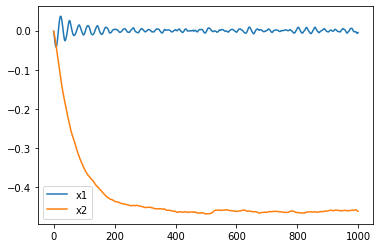

In [110]:
plt.plot(x1_for_plots, label="x1")
plt.plot(x2_for_plots, label="x2")
plt.legend()

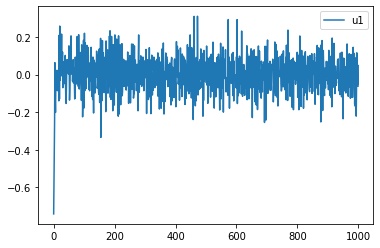

In [111]:
plt.plot(u1_for_plots, label="u1")
plt.legend()

In [120]:
env.close()